In [1]:
from yolov3 import make_yolov3_model
from utils.utils import WeightReader
from utils.utils import preprocess_input
from utils.utils import decode_netout
from utils.utils import correct_yolo_boxes
from utils.utils import do_nms
from utils.bbox import draw_boxes
from utils.utils import get_yolo_boxes

import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import cv2
import os

F:\Users\heecheol\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [3]:
infer_model, seq_infer_model = make_yolov3_model()
infer_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
__________________________________________________________________________________________________
zero_paddi

In [4]:
if not (os.path.exists('Weights/yolov3.h5')):
    weight_reader = WeightReader('yolov3.weights')
    weight_reader.load_weights(infer_model)
    infer_model.save_weights('Weights/yolov3.h5')
else:
    infer_model.load_weights('Weights/yolov3.h5', by_name=True)
    seq_infer_model.load_weights('Weights/yolov3.h5', by_name=True)

In [5]:
img_path='F:/DataSet/coco/JPEGImages/000000005535.jpg'
img = cv2.imread(img_path)
image_h, image_w, _ = img.shape
process_image = preprocess_input(img, net_h, net_w)

In [6]:
yolos = infer_model.predict(process_image)
prev_feature = yolos[3:]
yolos = yolos[:3]

In [8]:
boxes = []
for i in range(len(yolos)):
    if i!=0:
        continue
    # decode the output of the network
    yolo_anchors = anchors[(2 - i) * 6:(3 - i) * 6]
    boxes += decode_netout(yolos[i][0], yolo_anchors, obj_thresh, net_h, net_w)
# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)
# suppress non-maximal boxes
do_nms(boxes, nms_thresh)

draw_boxes(img, boxes, labels, obj_thresh)
cv2.imshow('predict', cv2.resize(img, (1280, 720)))
cv2.waitKey(0)

[xmin = 20,ymin = 123,xmax = 508,ymax = 362,c = 0.9996568,classes = 5,i = 83,b = 1]
[xmin = 484,ymin = 211,xmax = 627,ymax = 482,c = 0.99416095,classes = 0,i = 115,b = 1]


99

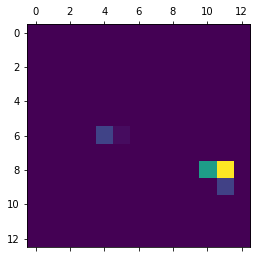

In [24]:
row = 8
col = 11
b=1
person_output=infer_model.output[0][:,row,col,b*85:b*85+6]
last_conv_layer = infer_model.get_layer('leaky_80')
grads = K.gradients(person_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([infer_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([process_image])
for i in range(last_conv_layer.output.shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [25]:
# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
#superimposed_img = np.uint8(superimposed_img)
cv2.imwrite('result2.jpg',superimposed_img)
#cv2.imshow('result', superimposed_img)
#cv2.waitKey(0)

True

In [ ]:
# We use cv2 to load the original image
img = cv2.imread('F:/DataSet/coco/JPEGImages/000000002983.jpg')

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


In [ ]:
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
superimposed_img = np.uint8(superimposed_img)
cv2.imshow('result', superimposed_img)
cv2.waitKey(0)